The point of this pipeline(s) is to reproduce the less computationally intensive models used in the paper by Candelori et al. as benchmarks for the ST-Transformer. We will work with:
- logistic regression model
- SVC
- Correlation Classifier based on the Pearson coefficient

In [28]:
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
import numpy as np
from scipy.stats import pearsonr
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer 
from joblib import Parallel, delayed 
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import warnings

To do an initial assesment of the accuracy of the different models I tought it was appropriate to perform the evaluation using a dataset that spanned the time points from the Go_Signal to the onset of movement, meaning that I considered a range t_go:t_go+RT_avg 

In [2]:
matrix_GO=np.load('matrix_3000-3600.npy')

In [3]:
#In the first part of this evaluation I decided to go with a higher temporal resolution, as it still allows the process to be computationally feasibile while providing more detailed information
bin_size=10
#The n_bins variable signifies amount of bins in which the timepoints are going to be split, in our case the bin_size is 10 milliseconds and we have a 600 milliseconds time interval so we will get 60 bins
n_bins=matrix_GO.shape[0]//bin_size
#We check that the matrix can actually be split in the way we want to
matrix_GO=matrix_GO[:n_bins*bin_size,:,:]
#Now we will reshape the array from a (600, 795, 166) array into a (795,166,60) array
matrix_GO=matrix_GO.reshape(n_bins,bin_size,matrix_GO.shape[1],matrix_GO.shape[2])
matrix_GO=matrix_GO.sum(axis=1)
matrix_GO = matrix_GO.transpose(1, 2, 0)
print(matrix_GO.shape)

(795, 166, 60)


Text(0, 0.5, 'Neuroni')

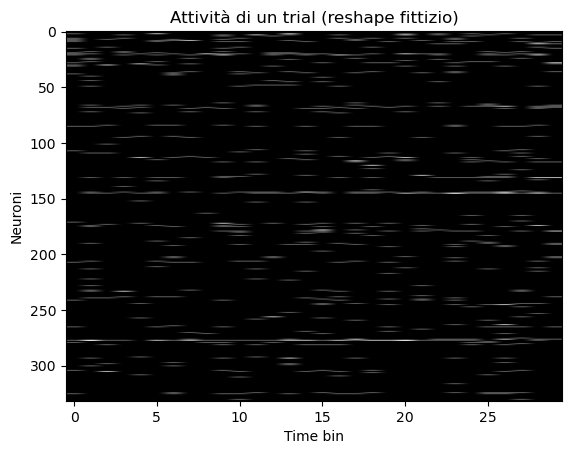

In [4]:
#I made this graph to check if the information in data was preseverd after the binning, and this raster plot seems pretty informative to me
plt.imshow(matrix_GO[0][:131970].reshape(-1, 30), aspect='auto', cmap='gray')
plt.title("Attività di un trial (reshape fittizio)")
plt.xlabel("Time bin")
plt.ylabel("Neuroni")
#This is also a good occasion to visualize the data we are examining: neurons are listed and their activity is codified by either a 0=inactive or a 1=active


In order to work with the models we plan to use we will need to flatten the 3D array, so we will transform the array (time, trials, neurons) into a matrix (trial, neurons*time).

In [5]:
matrix_GO= matrix_GO.reshape(795, 166 * 60)
#In order to use the sklearn models I also converted the 2D numpy matrix into a DataFrame
matrix_GO= pd.DataFrame(matrix_GO)
print(matrix_GO)

     0     1     2     3     4     5     6     7     8     9     ...  9950  \
0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
790   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
791   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
792   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
793   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
794   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

     9951  9952  9953  9954  9955  9956  9957  9958  9959  
0  

In [6]:
#This DataFrame contains the information about movement direction
BHV_GO=pd.read_csv('nostop_BHV_GO.csv')

In [7]:
#The data we will use to train and evaluate the model is exclusively about the Go_Trials described the in paper by Candelori et al.. 
X=matrix_GO
y=BHV_GO['TargetPos']
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                               test_size=0.2,
                                               random_state=42,
                                               stratify=y)

In [8]:
#Checking if the data is balanced
print(np.unique(y, return_counts=True))

(array([1., 2.]), array([399, 396], dtype=int64))


In [9]:
#Checking that the number of rows matches in the X and y
print(X.shape)
print(y.shape[0])

(795, 9960)
795


Now that we have a dataset that our models can actually work with we will need to write the actual pipelines, in order to speed up the process we will use the make_pipeline function form sklearn and we will use a feature reduction tool to make the process less computationally intensive.

When I started to work on this project I planned to use the NDT from Kording Lab, unfortunately the port to Python of the MatLab-native package lacks all the models I plan on using and a Correlation Classifier isn't available on sklearn either, so I wrote a simple one based on the Pearson correlation coefficient and made it compatible with both Pandas and cross_val_score 

In [10]:
class CorrelationClassifier(BaseEstimator, ClassifierMixin):
    #This fit() function builds a template by taking the mean of the acitivity of each neuron for one movement direction
    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
        
        self.classes_ = np.unique(y)
        self.templates_ = {
            c: X[y == c].mean(axis=0) for c in self.classes_
        }
        return self
#The predict() function takes the data and calculates the Pearson's correlation coefficient with the template for each label and find then takes the label with the best value
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        preds = []
        for x in X:
            corrs = {
                c: pearsonr(x, tmpl)[0] for c, tmpl in self.templates_.items()
            }
            best_class = max(corrs, key=corrs.get)
            preds.append(best_class)
        return np.array(preds)
#In the score() we compare the predictions made by the model with the test labels and we get an average 
    def score(self, X, y):
        y_pred = self.predict(X)
        if isinstance(y, pd.Series):
            y = y.values
        return np.mean(y_pred == y)

In [11]:
#For all the models examined I decided to use SelectKBest() with a mutual information classifier and picked only the 100 most informative features
#The LogisticRegression() model from sklearn applies regularization by default, so I decided to not use StandardScaler in the pipeline, however I still used SelectKBest to reduce the amount of features and make the process go quicker
logreg=make_pipeline(
    SelectKBest(score_func=mutual_info_classif, k=100),
    LogisticRegression(penalty='l2',max_iter=100)
)
svm=make_pipeline(
    SelectKBest(score_func=mutual_info_classif, k=100),
    StandardScaler(),
    SVC(kernel='rbf',C=0.1,gamma='scale')
)
#For the Correlation Classifier regularization is not reccomended as the model makes a template based on the actual values of the features and it doesn't make sense to penalize towards a certain solution like we do with l_2 regularization for the LR model
cc=make_pipeline(
    SelectKBest(score_func=mutual_info_classif, k=100),
    CorrelationClassifier()
)

In [12]:
#I opted for a cross evaluation score in order to get a more accurate mean accuracy for the models, however I decided to keep the K to 5 in order to make the process more computationally feasible
scores_lr = cross_val_score(logreg, X, y, cv=5)
scores_svm = cross_val_score(svm, X, y, cv=5)
scores_cc = cross_val_score(cc, X, y, cv=5)

In [13]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM RBF", "Correlation Classifier"],
    "Accuracy Mean": [scores_lr.mean(), scores_svm.mean(), scores_cc.mean()],
    "Accuracy Std": [scores_lr.std(), scores_svm.std(), scores_cc.std()]
})

print(results)


                    Model  Accuracy Mean  Accuracy Std
0     Logistic Regression       0.901887      0.026564
1                 SVM RBF       0.874214      0.017338
2  Correlation Classifier       0.797484      0.028239


In [14]:
models={
    "Logistic Regression":logreg,
    "SVM":svm,
    "Correlation Classifier":cc
}

              precision    recall  f1-score   support

         1.0       0.92      0.91      0.91       399
         2.0       0.91      0.92      0.91       396

    accuracy                           0.91       795
   macro avg       0.91      0.91      0.91       795
weighted avg       0.91      0.91      0.91       795

              precision    recall  f1-score   support

         1.0       0.88      0.86      0.87       399
         2.0       0.86      0.89      0.88       396

    accuracy                           0.87       795
   macro avg       0.87      0.87      0.87       795
weighted avg       0.87      0.87      0.87       795

              precision    recall  f1-score   support

         1.0       0.73      0.88      0.80       399
         2.0       0.85      0.68      0.75       396

    accuracy                           0.78       795
   macro avg       0.79      0.78      0.78       795
weighted avg       0.79      0.78      0.78       795



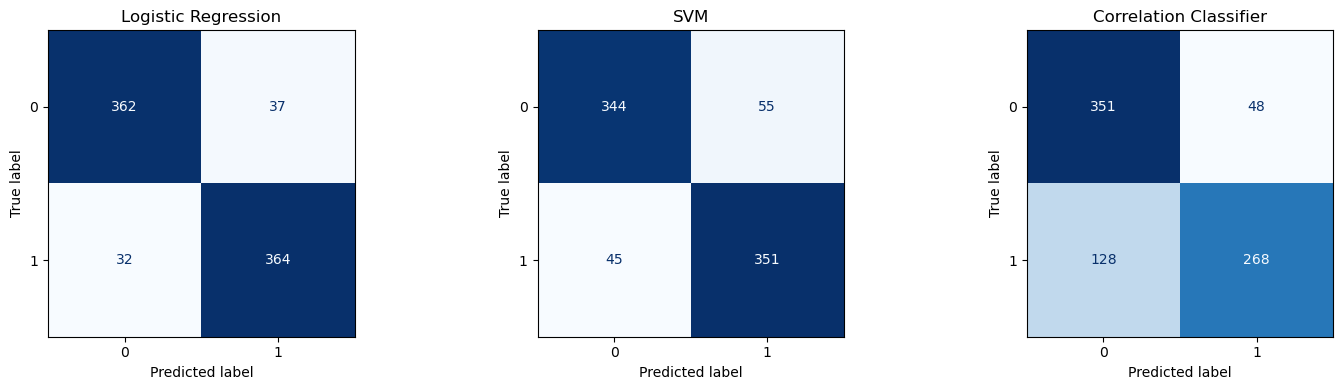

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
#In order to understand better the performance of these models I decided to plot the confusion matrix for each model
for ax, (name, model) in zip(axes, models.items()):
    y_pred = cross_val_predict(model, X, y, cv=5)
    print(classification_report(y,y_pred))
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(name)

plt.tight_layout()
plt.show()    

I also printed the classification report for each model in order to see exactly where and how the models go wrong.
Let's explain each value in the classification report:
- precision is defined as the number of true positives over the the total number of positives
- recall is defined ad the number of true positives over the sum of the true positives and false negatives
- the F_1 score is just the harmonic median of precision and recall

In [16]:
#In this cell I split the training data into 50 ms time bins in order to evaluate the performance for each of them cumulatively, as I want to see which time window is the most informative because I suspect, reasonably I might add, that the most informative time window for all the model ranges from the Go_signal to the onset of movement
matrix_acc_curve=np.load("matrix_acc_curve.npy")
matrix_acc_curve=matrix_acc_curve.transpose(1,2,0)
bin_size=50
max_time=matrix_acc_curve.shape[2]//bin_size*bin_size
matrix_acc_curve=matrix_acc_curve[:,:,:max_time]
n_bins=max_time//bin_size
matrix_acc_curve=matrix_acc_curve.reshape(
    matrix_acc_curve.shape[0],matrix_acc_curve.shape[1], n_bins, bin_size
).sum(axis=-1)
X=matrix_acc_curve

In [29]:
#This is just here so we get a cleaner output without any warnings
warnings.filterwarnings('ignore') 
#Here I define a function that evaluates each model by firstly flattening the data and the running each model 5 times with different sampling from the data 
def evaluate_models(models, X, y,window_size,step,cv=5, max_parallel=3):
    #I opted for a sliding window mechanism that takes into consideration 10 time bins at a time with a 5 time bins step as to determine the most informative segment in time
    n_bins=X.shape[2]
    windows=[(start,start+window_size) for start in range(0,n_bins-window_size+1, step)]
    results={model_name:[] for model_name in models}
    results_std={model_name:[] for model_name in models}
    for model_name, model in models.items():
        print(f"\nEvaluating model : {model_name}")
        start_time=time.time()
        for (start_bin,end_bin) in tqdm(windows, desc=f"{model_name} sliding windows"):
            try:
                X_window=X[:,:,start_bin:end_bin].reshape(X.shape[0],-1)
                model_clone=clone(model)
                cv_split=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
                scores=cross_val_score(model_clone,X_window, y, cv=cv_split,
                                       scoring=make_scorer(accuracy_score), n_jobs=max_parallel)
                results[model_name].append(np.mean(scores))
                results_std[model_name].append(np.std(scores))
            except Exception as e:
                print(f" Error with {model_name} on window {start_bin}-{end_bin}: {str(e)}")
                results[model_name].append(np.nan)
                results_std[model_name].append(np.nan)
    return windows, results, results_std
   

In [34]:
def plot_results(windows, results, results_std, bin_size=50, go_signal=3000, move_onset=3600):
    x_bins=[np.mean(w) for w in windows]
    x_ms=[c*bin_size for c in x_bins]
    x_aligned=[t-go_signal for t in x_ms]
    plt.figure(figsize=(10,6))
    for model_name, accs in results.items():
        stds=results_std[model_name]
        plt.errorbar(x_aligned,accs,yerr=stds, label=model_name, capsize=4, marker='o')
    move_onset_aligned=move_onset-go_signal
    plt.axvline(x=move_onset_aligned, color='red', linestyle='--', label=f"Move_Onset ({move_onset} ms)")
    plt.axvline(x=0, color='blue', linestyle='--', label=f"Go_Signal" )
    plt.xlabel("Tempo (ms, allineato a Go_Signal=0)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy con Sliding Window (5-fold CV)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
windows,results,results_std=evaluate_models(
    models=models,
    X=X,
    y=y,
    window_size=10,
    step=5,
    cv=5,
    max_parallel=3
)

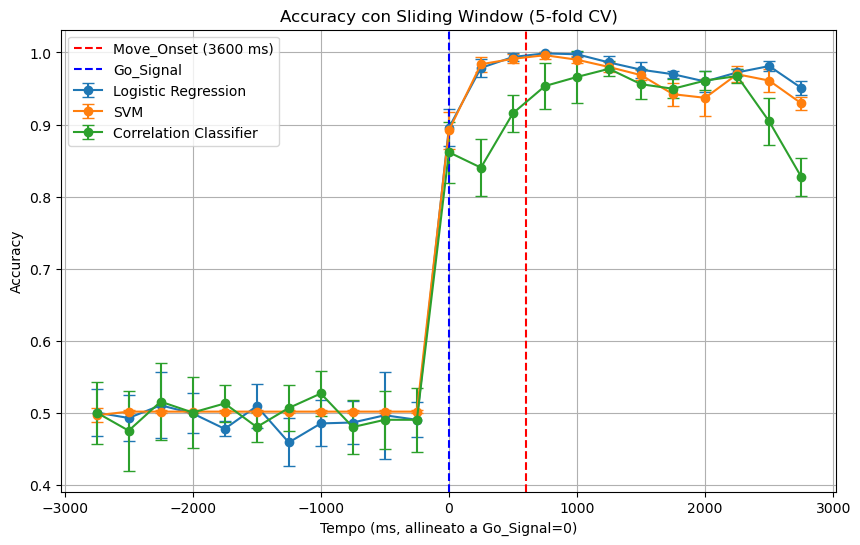

In [35]:
plot_results(windows,results,results_std)

As we can see the accuracy curve confirms my suspicion, confirming the idea that movement can be predicted the best by examing the time window in between the Go_Signal and the onset of movement.

In [36]:
print(windows)

[(0, 10), (5, 15), (10, 20), (15, 25), (20, 30), (25, 35), (30, 40), (35, 45), (40, 50), (45, 55), (50, 60), (55, 65), (60, 70), (65, 75), (70, 80), (75, 85), (80, 90), (85, 95), (90, 100), (95, 105), (100, 110), (105, 115), (110, 120)]
